In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotnine as p9
import random

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor


pd.options.display.max_columns= None


from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Raleway']

In [91]:
data = pd.read_csv('barkbeetle_dataset.csv')

data['timestamp'] = pd.to_datetime(data['timestamp'])

In [92]:
# TODO: move to other notebook
data['area_endangered'] = data[['forest_ownership', 'area_nse', 'area_se']].apply(lambda x: x[1] if x[0] == 'NSW' else x[2], axis=1)

In [93]:
# TODO: remove pre 2006 and post feb2020 
data = data[data['timestamp'].isin(pd.date_range(start='2006-01-01', end='2020-02-29', freq='M'))]

In [94]:
# pre-filter for features and train test split to prevent data leakage
y = data['infested_wood']
X = data[['timeframe', 'id', 'area_endangered', 'timestamp', 'centroid_xcoord', 'centroid_ycoord', 
          'TM0', 'RRK', 'KWK', 'prev_infested_wood', 'TM0_rollyr', 'RRK_rollyr', 'KWK_rollyr', 'prev_infested_wood_rollyr']]

## train-val-test split

In [112]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1 - train_ratio, 
                                                    random_state=0)

# test is now 10% of the initial data set
# validation is now 10% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + validation_ratio), 
                                                random_state=0, 
                                                shuffle=False)  # shuffle already done in first split

# Show the results of the split
print ('Training set has {} samples.'.format(X_train.shape[0]))
print ('Validation set has {} samples.'.format(X_val.shape[0]))
print ('Testing set has {} samples.'.format(X_test.shape[0]))

Training set has 9515 samples.
Validation set has 1189 samples.
Testing set has 1190 samples.


In [113]:
# remove and save ids and timestamps from the sets
id_train, ts_train = X_train.pop('id'), X_train.pop('timestamp')
id_val, ts_val = X_val.pop('id'), X_val.pop('timestamp')
id_test, ts_test = X_test.pop('id'), X_test.pop('timestamp')

## Engineer Month Feature

In [114]:
# TODO: diese Funktion als custom pipeline

def month_num_encoder(X_train, y_train, X_val, X_test):
    '''
    TODO: documentation
    '''
        
    # get a factor for every timeframe
    # factor = how much of the yearly infestation was observed in the respective timeframe
    
    # merge timeframe column from X_train with y_train (target)
    tf_y = pd.DataFrame({'timeframe': X_train['timeframe'], 'target': y_train})
    
    # group by timeframe and take the mean of target
    tf_y = tf_y.groupby('timeframe').mean()
    
    # get the sum of all groups
    total = tf_y['target'].sum()
    
    # make a dictionary that maps the timeframe to the ratio it contributes to the target on average
    transform_dict = tf_y['target'].map(lambda x: x/total).to_dict()
    
    # use these factors (one numerical feature) in train, val and test sets
    # instead of the timeframe feature (categorial with 8 categories)
    # since we only used the knowledge on our targets of the train set (y_train) there is no data leakage 
    
    new_X_train = X_train.copy()
    new_X_train['timeframe'] = new_X_train['timeframe'].map(lambda x: transform_dict.get(x))
    new_X_val = X_val.copy()
    new_X_val['timeframe'] = new_X_val['timeframe'].map(lambda x: transform_dict.get(x))
    new_X_test = X_test.copy()
    new_X_test['timeframe'] = new_X_test['timeframe'].map(lambda x: transform_dict.get(x))
    
    return new_X_train, new_X_val, new_X_test

In [115]:
# use function to encode the months in timeframe column
X_train, X_val, X_test = month_num_encoder(X_train, y_train, X_val, X_test)

## Pipeline

In [116]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 3409 to 3092
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   timeframe                  9515 non-null   float64
 1   area_endangered            9515 non-null   float64
 2   centroid_xcoord            9515 non-null   float64
 3   centroid_ycoord            9515 non-null   float64
 4   TM0                        9515 non-null   float64
 5   RRK                        9515 non-null   float64
 6   KWK                        9515 non-null   float64
 7   prev_infested_wood         9513 non-null   float64
 8   TM0_rollyr                 9502 non-null   float64
 9   RRK_rollyr                 9502 non-null   float64
 10  KWK_rollyr                 9502 non-null   float64
 11  prev_infested_wood_rollyr  9500 non-null   float64
dtypes: float64(12)
memory usage: 966.4 KB


In [117]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    # ('std_scaler', StandardScaler()) # Standardscaler not needed for now as we use Decision Tree Based Models
])

# Pipeline for categorical features 
# don't have those for now but keep it in for robustness' sake
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [118]:
# Creating list for categorical predictors/features 
# Should not have any but we leave it in for robustness sake (TODO:remove)
cat_features = list(X_train.columns[X_train.dtypes==object])
print(cat_features)

# Creating list for numerical predictors/features
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(X_train.columns[X_train.dtypes!=object])
print(num_features)

[]
['timeframe', 'area_endangered', 'centroid_xcoord', 'centroid_ycoord', 'TM0', 'RRK', 'KWK', 'prev_infested_wood', 'TM0_rollyr', 'RRK_rollyr', 'KWK_rollyr', 'prev_infested_wood_rollyr']


In [121]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_xgbr = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbr', XGBRegressor(objective='reg:squarederror'))
])

In [122]:
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe_xgbr, X_train, y_train, cv=5)

In [127]:
# Calculating the mean sqaured error, mean absolute error and explained variance for XGBRegressor
print('Cross validation scores:')
print('-------------------------')
print("MSE: {:.2f}".format(mean_squared_error(y_train, y_train_predicted)))
print("MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predicted)))
print("Explained Variance: {:.2f}".format(explained_variance_score(y_train, y_train_predicted)))

Cross validation scores:
-------------------------
MSE: 3333571.21
MAE: 220.53
Explained Variance: 0.40


In [147]:
# optimizing
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# we have to add 'logreg__' infront of the corresponding hyperparameters. 
param_xgbr = {"xgbr__learning_rate"    : [0.02, 0.05, 0.10, 0.15, 0.20] ,
              "xgbr__max_depth"        : [2, 3, 4, 5, 6, 8, 10, 12],
              "xgbr__subsample"        : [0.5, 0.75, 1],
              "xgbr__min_child_weight" : [1, 2, 3, 4, 5],
              "xgbr__gamma"            : [0.0, 0.05, 0.1, 0.2 , 0.3],
              "xgbr__colsample_bytree" : [0.4, 0.5 , 0.7, 0.8, 1, 1.2],
              'xgbr__n_estimators'     : [100, 150, 200, 250, 300]
             }

grid_xgbr = RandomizedSearchCV(pipe_xgbr, param_distributions=param_xgbr, cv=4, scoring='neg_mean_squared_error', 
                           verbose=1, n_jobs=-1, random_state=0, n_iter=2000)

In [148]:
grid_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3249 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 4869 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 5800 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 6813 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 7906 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 9081 tasks      | 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer_num',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['timeframe',
                                                                                'area_endangered',
                                                                                'centroid_xcoord',
                                                                                'centroid_ycoord',
                                                                                'TM0',
                                                                                'RRK',
                   

In [149]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_xgbr.best_score_))
print("Best parameters:\n{}".format(grid_xgbr.best_params_))

Best score:
-2259637.47
Best parameters:
{'xgbr__subsample': 1, 'xgbr__n_estimators': 200, 'xgbr__min_child_weight': 3, 'xgbr__max_depth': 4, 'xgbr__learning_rate': 0.05, 'xgbr__gamma': 0.05, 'xgbr__colsample_bytree': 0.8}


In [150]:
# Save best model as best_model
best_model = grid_xgbr.best_estimator_['xgbr']

In [166]:
# Preparing the validation set 

# fitting our preprocessing pipeline only with training data
preprocessor.fit(X_train)
# transforming our test data with fitted preprocessor pipeline
X_train_preprocessed = preprocessor.transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

In [167]:
# Calculating the mean sqaured error, mean absolute error and explained variance for the optimized XGBRegressor
y_val_pred = best_model.predict(X_val_preprocessed)
y_train_pred = best_model.predict(X_train_preprocessed)

print("MSE: {:.2f}".format(mean_squared_error(y_val, y_val_pred)))
print("MAE: {:.2f}".format(mean_absolute_error(y_val, y_val_pred)))
print("Explained Variance: {:.2f}".format(explained_variance_score(y_val, y_val_pred)))
# TODO: F1-score in regression?

MSE: 2161557.89
MAE: 207.54
Explained Variance: 0.47


In [168]:
best_model.feature_importances_

array([0.16806196, 0.02302644, 0.04363305, 0.02397452, 0.02762127,
       0.03628454, 0.01582753, 0.16008867, 0.1621361 , 0.0863535 ,
       0.02092764, 0.23206483], dtype=float32)

[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 2, 2]

In [208]:
results_df = pd.concat([X_train, X_val])
results_df['id'] = pd.concat([id_train, id_val])
results_df['timestamp'] = pd.concat([ts_train, ts_val])
results_df['y_true'] = pd.concat([y_train, y_val])
results_df['y_pred'] = np.concatenate([y_train_pred, y_val_pred])
results_df['set'] = ['train'] * X_train.shape[0] + ['validation'] * X_val.shape[0]

In [209]:
id_subset = np.random.choice(results_df['id'].unique(), 10, replace=False)

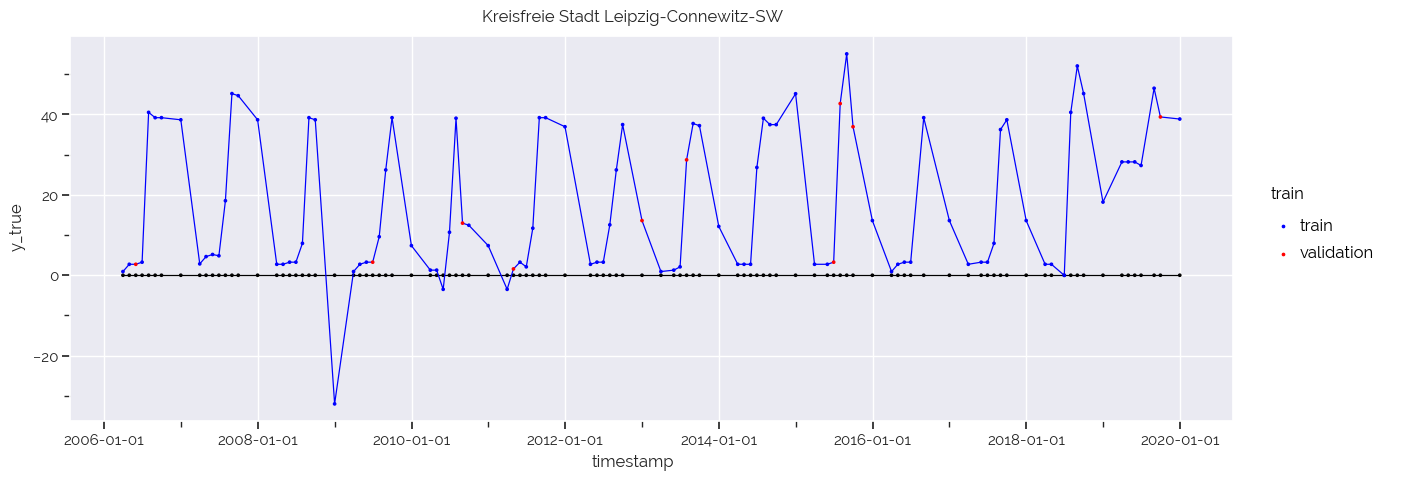

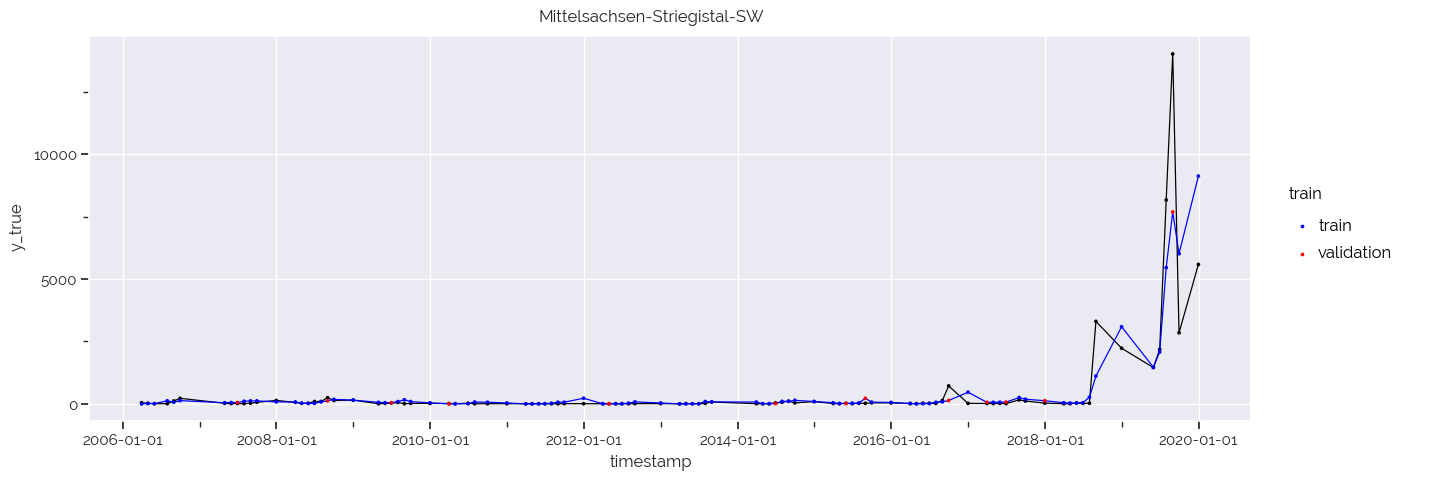

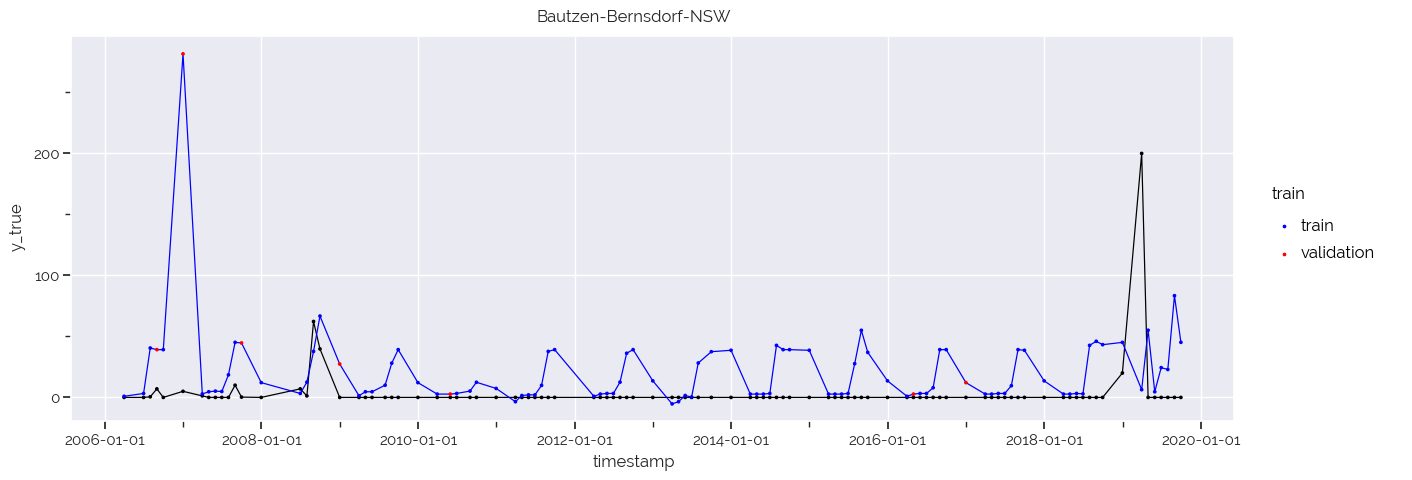

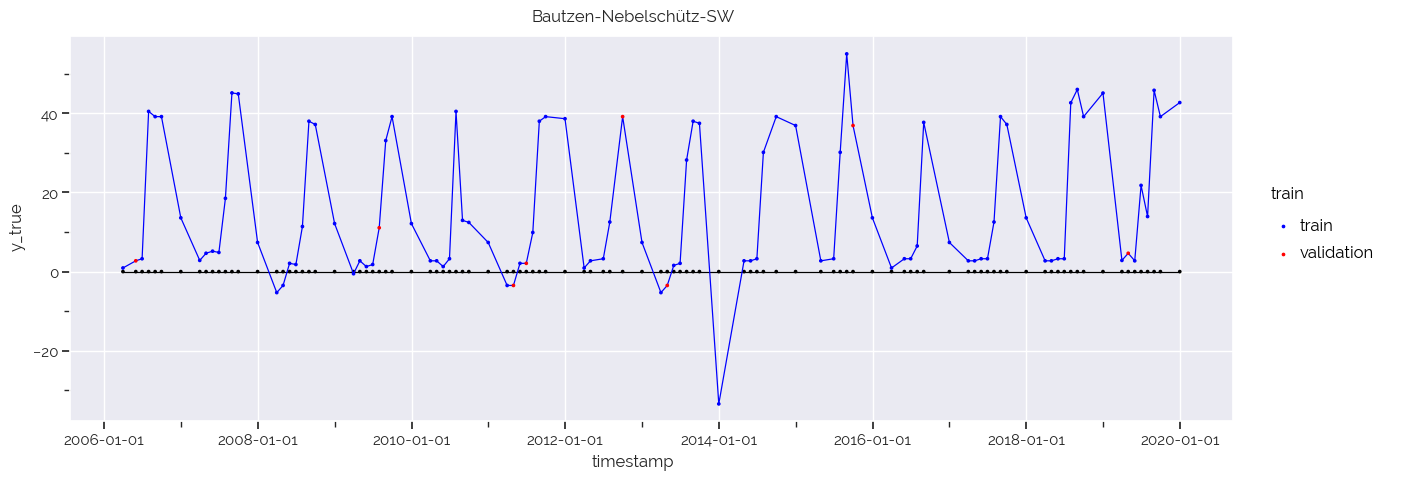

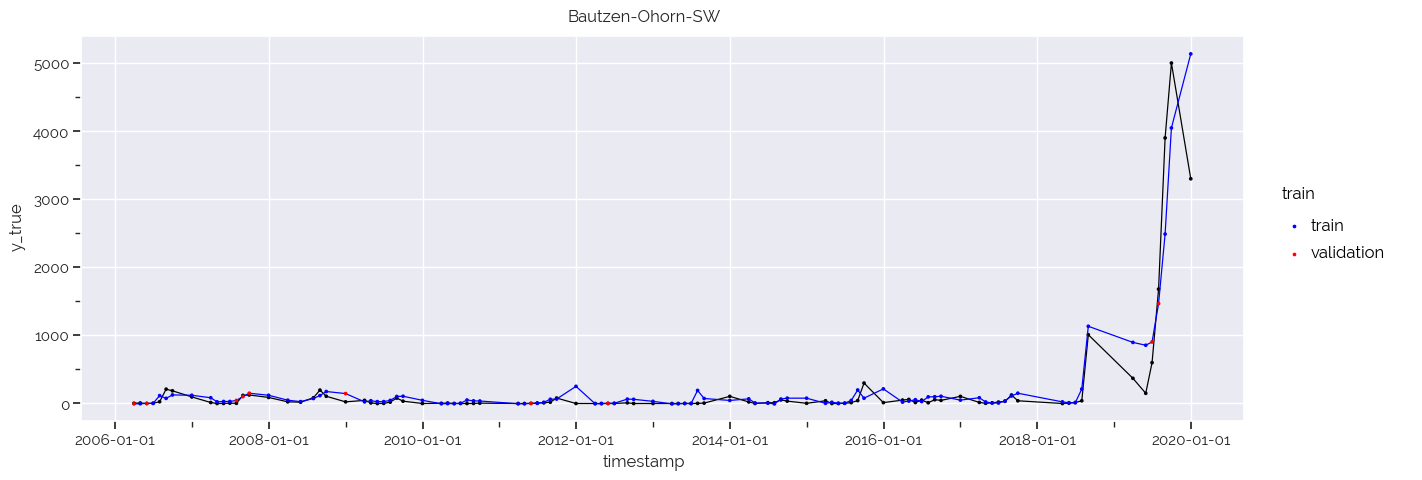

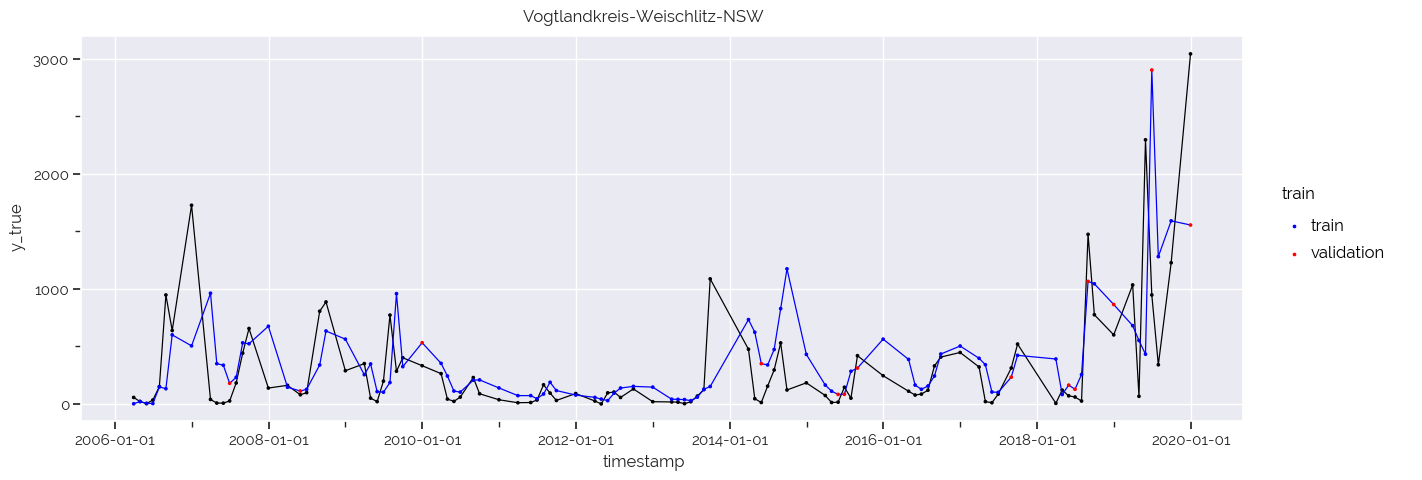

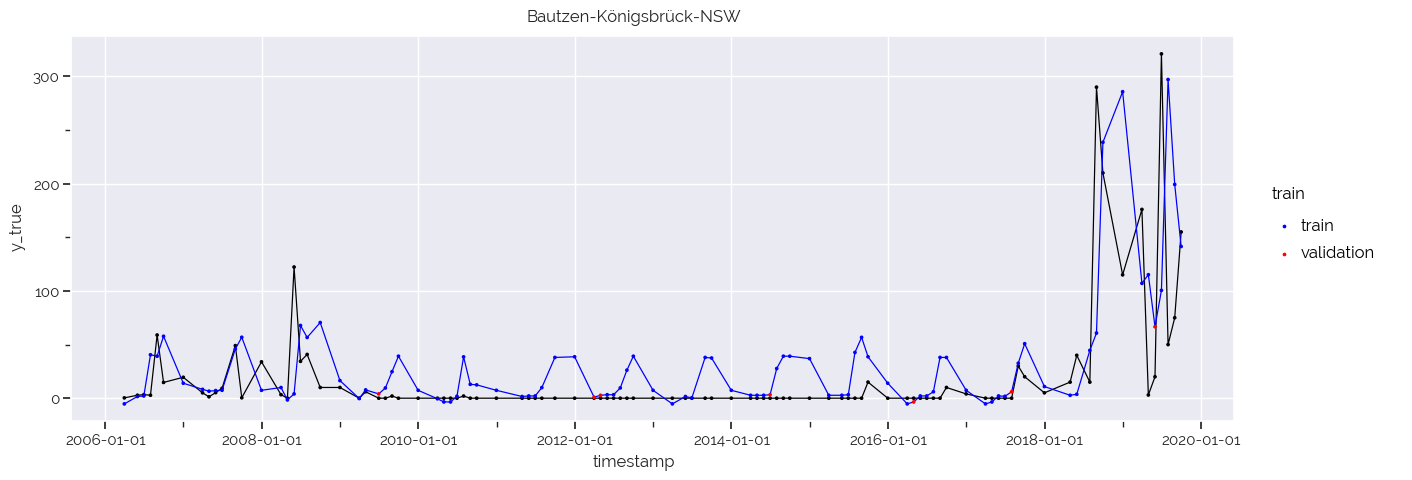

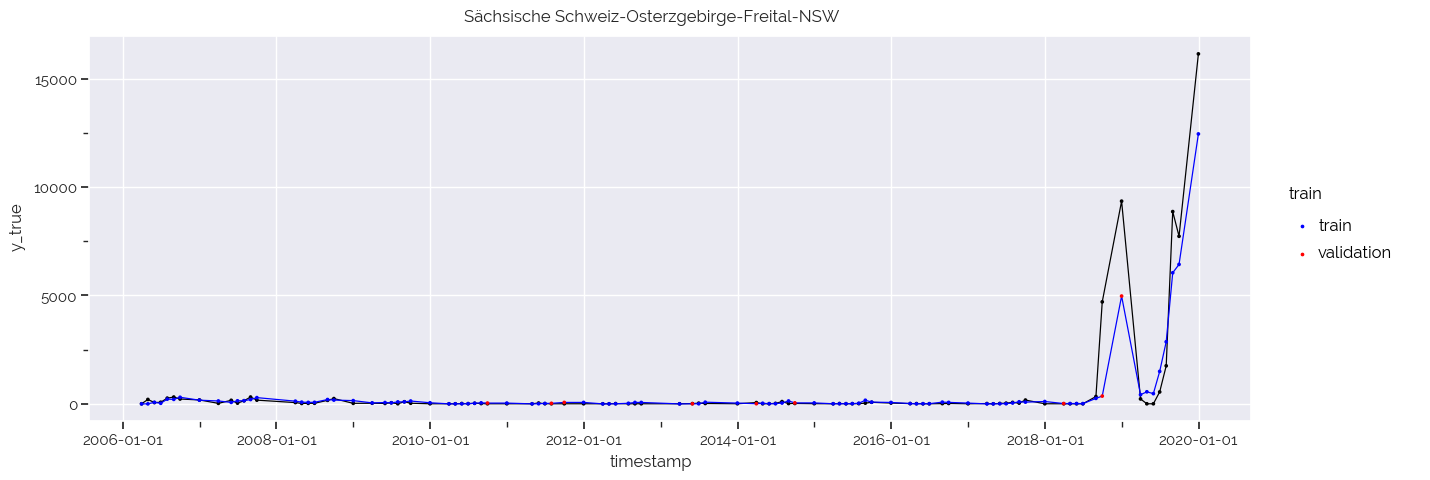

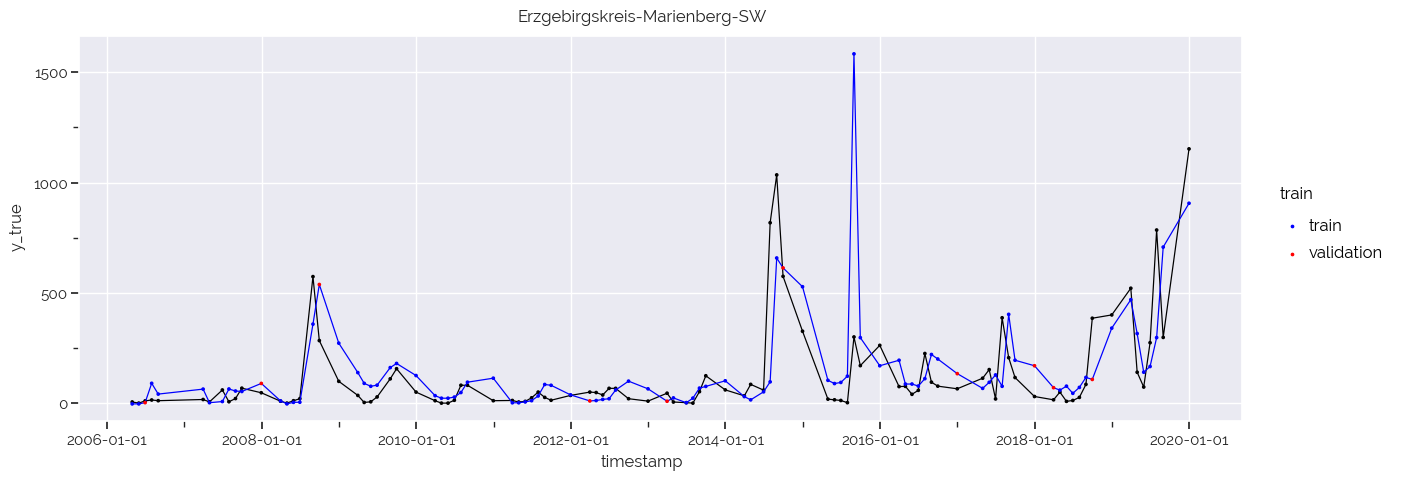

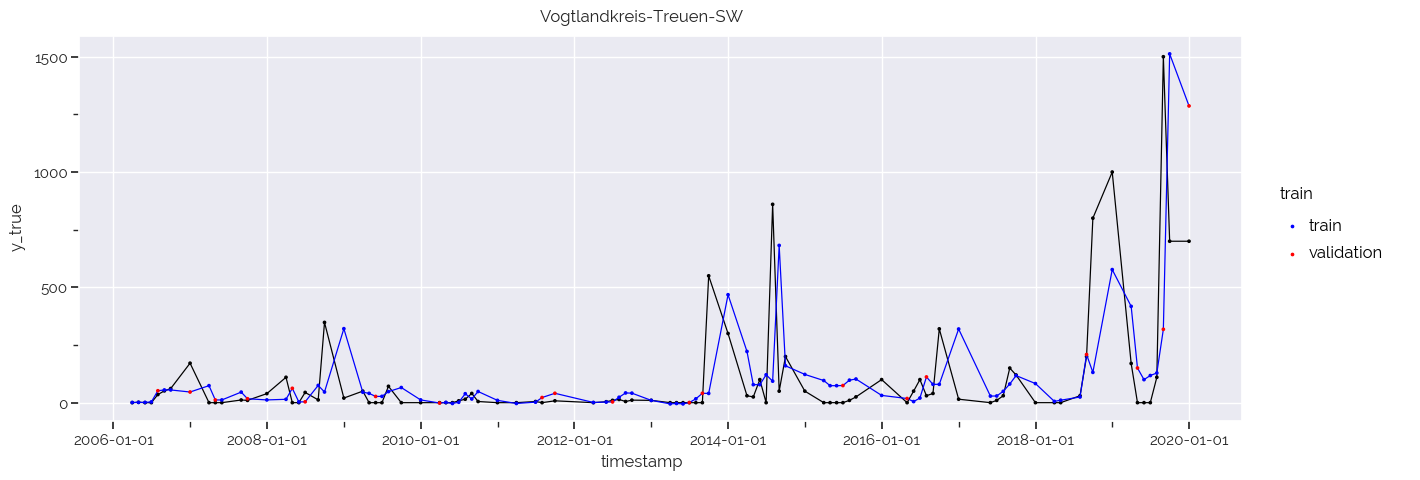

In [210]:
p9.options.figure_size = (15, 5)

for ID in id_subset:
    draw = results_df[results_df['id'] == ID]
    (
        p9.ggplot(draw)
        + p9.geom_line(p9.aes('timestamp', 'y_true'))
        + p9.geom_point(p9.aes('timestamp', 'y_true'), size=.5)
        + p9.geom_line(p9.aes('timestamp', 'y_pred'), color='blue')
        + p9.geom_point(p9.aes('timestamp', 'y_pred', color='train'), size=.5)
        + p9.scale_color_manual(['blue', 'red'])
        + p9.labels.ggtitle(ID)
        + p9.theme_seaborn()
    ).draw();